# Stage 3: Calculate the Attribution Scores for TRAK based methods
This notebook calculates the attribution scores for TRAK based methods such as TRAK and D-TRAK.
### Before attempting to run this notebook, make sure you already have:
- A trained model of interest (which can be obtained by running either train_sd1.sh or train_sd1_lora.sh in training_scripts/ \<dataset\>/)
- A test dataset of generated images from your model of interest, obtained by running SD1_Generate_Images.ipynb
- Existing TRAK projections, obtained by running TRAK/Train_TRAK.py (Note this may take some time!)

### What this notebook will do
This notebook will calculate TRAK scores for the test dataset of generated images, and will then use this to generate a counter factual dataset, which you can use with training_scripts/ \<dataset\>/train_sd1_(lora_)counterfactuals.sh to generate a counter factual dataset. Once that is complete, rerun this script with ```UPDATE_SCORES = False``` to generate a counter factual image.

In [ ]:
from utils.custom_enums import Model_Type_Enum, Dataset_Type_Enum, TRAK_Type_Enum, TRAK_Num_Timesteps_Enum
from utils.config import Project_Config, CIFAR_10_Config, CIFAR_10_Local_Config
from LDS.LDS_Utils import LDS
from TRAK.TRAK_utils import TRAK_Experiment_Config

### Configuration
The following code block sets the configuartion for this run through.
- ```dataset_type```: either CIFAR10 or CIFAR2, specifies which dataset to use.

- ```model_type```: either LORA or FULL, specifies which type of model to use (i.e. which type of model to generate attribution scores for).

- ```TRAK_type``` : either TRAK or DTRAK, specifies which TRAK method to use.  

- ```TRAK_num_timesteps```: either ONE, TEN, or HUNDRED. specifies how many timesteps are sampled per image in the (D-)TRAK method. 

- ```project_config```: allows for specifiying machine specific settings, such as specific the current working directory, if to use CUDA, or if to use Windows or Unix like file paths. Rather than changing it here, you should go edit the defaults in utils/config.py/Project_Config.\_\_init__()

- ```UPDATE_SCORES```: True/False, specifies if the TRAK scores should be update, on the first run for a given config this should be set to true, but can be turned off after.

In [ ]:
model_type = Model_Type_Enum.LORA
dataset_type = Dataset_Type_Enum.CIFAR10
TRAK_type = TRAK_Type_Enum.DTRAK
TRAK_num_timesteps = TRAK_Num_Timesteps_Enum.TEN

project_config = Project_Config()

UPDATE_SCORES = False

On CIFAR10 this notebook will take 10 min to run for LoRA models and 20 min to run for a full model. 

(If ```UPDATE_SCORES``` is False it should be much faster.)

In [ ]:
#Internal config for unfinished content
SWAP_DATASETS = False
CALCULATE_LDS = False

#Setup environment
trak_config = TRAK_Experiment_Config(
    project_config=project_config,
    model_type=model_type,
    TRAK_type=TRAK_type,
    dataset_type=dataset_type,
    TRAK_num_timesteps=TRAK_num_timesteps,
    FORCE_FULL_MODEL_TEST_DATASET=SWAP_DATASETS
    )

model_config = trak_config.model_config

f = project_config.folder_symbol
base_save_path = (project_config.PWD + f + 
                  "datasets" + f +
                  "generated-" + dataset_type + f +
                  trak_config.MODEL_NAME_CLEAN)

if dataset_type == Dataset_Type_Enum.CIFAR10:
    train_dataset_config = CIFAR_10_Config()
if dataset_type == Dataset_Type_Enum.CIFAR2:
    train_dataset_config = CIFAR_10_Local_Config(
        project_config=project_config,
        dataset_type=dataset_type
    )

generated_dataset_config = CIFAR_10_Config(huggingface_slug=base_save_path, existing_image_column_name="image")

import torch
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


TRAK is being saved to /home/joy/Lboro/CodeServer/git/Data-Attribution-for-Stable-Diffusion/TRAK/results/cifar10/DTRAK_sd1-lora_timestep-10


Load in our TRAKer instance.

In [3]:
traker, tokenizer, text_encoder, vae, unet, ckpts = trak_config.load_TRAKer(len(train_dataset_config.dataset))

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
INFO:STORE:Existing model IDs in /home/joy/Lboro/CodeServer/git/Data-Attribution-for-Stable-Diffusion/TRAK/results/cifar10/DTRAK_sd1-lora_timestep-10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
INFO:STORE:Model IDs that have been finalized: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
INFO:STORE:Existing TRAK scores:
INFO:STORE:sd1-lora_normal_test_dataset: /home/joy/Lboro/CodeServer/git/Data-Attribution-for-Stable-Diffusion/TRAK/results/cifar10/DTRAK_sd1-lora_timestep-10/scores/sd1-lora_normal_test_dataset.mmap
INFO:STORE:sd1-lora_full_model_test_dataset: /home/joy/Lboro/CodeServer/git/Data-Attribu

Model contains 797184 trainable parameters


Load in the training and test (generated) datasets

Dataset({
    features: ['image', 'label_txt'],
    num_rows: 50000
})
Dataset({
    features: ['image', 'label_txt'],
    num_rows: 200
})


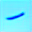

In [4]:
train_dataset = train_dataset_config.preprocess(tokenizer)
print(train_dataset)
generated_dataset = generated_dataset_config.preprocess(tokenizer)
print(generated_dataset)

# DataLoaders creation:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=False,
    collate_fn=train_dataset_config.collate_fn,
    batch_size=1,
)

# DataLoaders creation:
generated_dataloader = DataLoader(
    generated_dataset,
    shuffle=False,
    collate_fn=generated_dataset_config.collate_fn,
    batch_size=1,
)

train_dataset_config.dataset[6]['image']
train_dataset[6]["image"]
generated_dataset_config.dataset[6]['image']
generated_dataset[6]["image"]

In [5]:
#Scoop whatever VRAM we can because this is going to be a tight fit
import gc
gc.collect()
torch.cuda.empty_cache()

Calculate the TRAK scores on our training set

In [ ]:
weight_dtype = torch.float32

if UPDATE_SCORES:
    for model_id, ckpt in enumerate(tqdm(ckpts)):
        if trak_config.model_type == Model_Type_Enum.LORA:
            p = trak_config.model_config.getModelDirectory()
            unet = model_config.loadLoRAUnet(p,ckpt)
            ckpt_local = unet.state_dict()
        else:
            ckpt_local = ckpt

        traker.start_scoring_checkpoint(exp_name=trak_config.EXPERIMENT_NAME,

                                            checkpoint=ckpt_local,

                                            model_id=model_id,

                                            num_targets=len(generated_dataloader))
        

        for batch in tqdm(generated_dataloader):
                if project_config.IS_CUDA:
                    batch = [x.cuda() for y,x in batch.items()]
                else:
                    batch = [x for y,x in batch.items()]
                image = batch[0]
                tokens = batch[1]
                # Convert images to latent space
                latents = vae.encode(image.to(weight_dtype)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor
                encoder_hidden_states = text_encoder(tokens, return_dict=False)[0]

                batch = [latents, encoder_hidden_states]
                traker.score(batch=batch, num_samples=batch[0].shape[0])

    scores = traker.finalize_scores(exp_name=trak_config.EXPERIMENT_NAME)

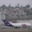

In [7]:
train_dataset[0]["image"]

Next we show the attribution in action. Below is a set of 10 example test images, (left most column) and the top scoring (highest attribution, most influential) images from the training data. The code to display these is adpated from https://github.com/MadryLab/trak/blob/main/examples/cifar_quickstart.ipynb.

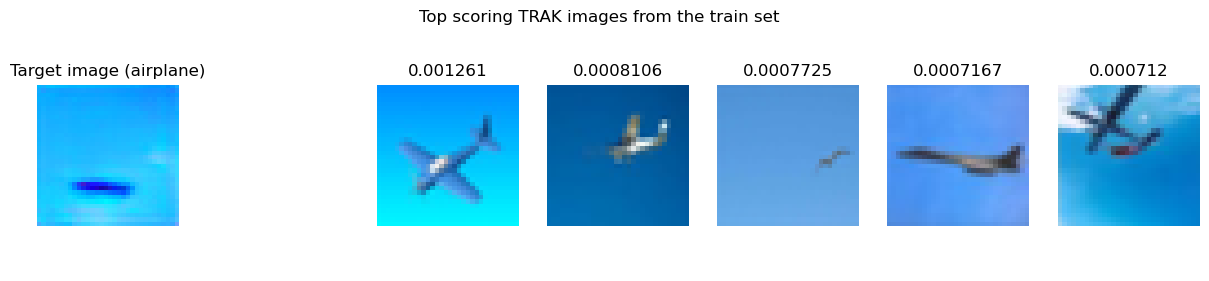

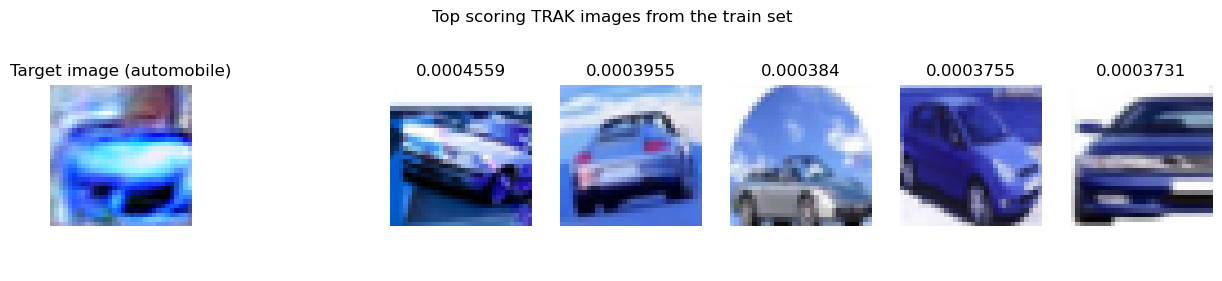

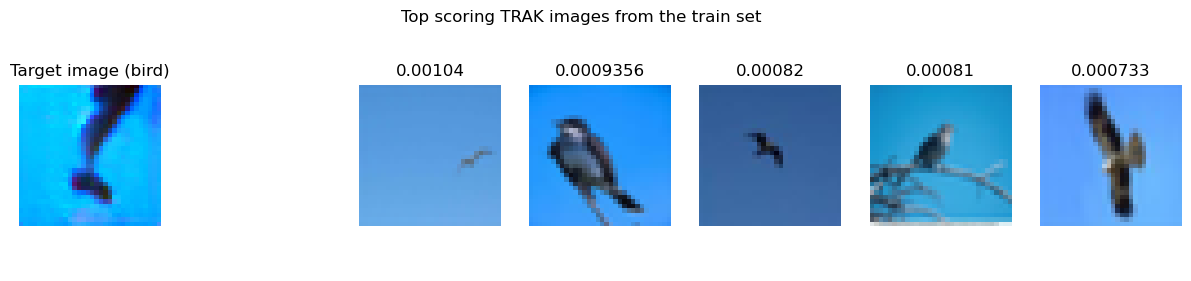

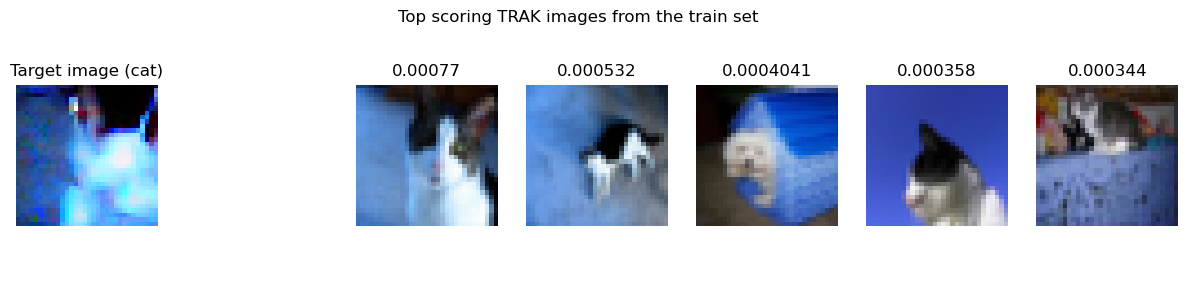

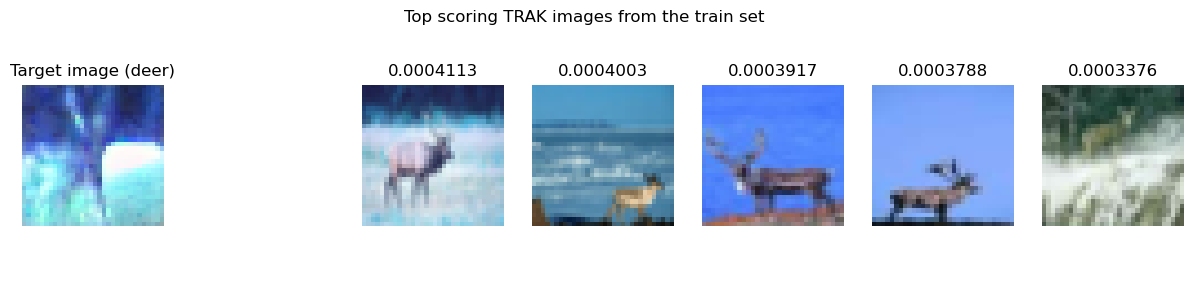

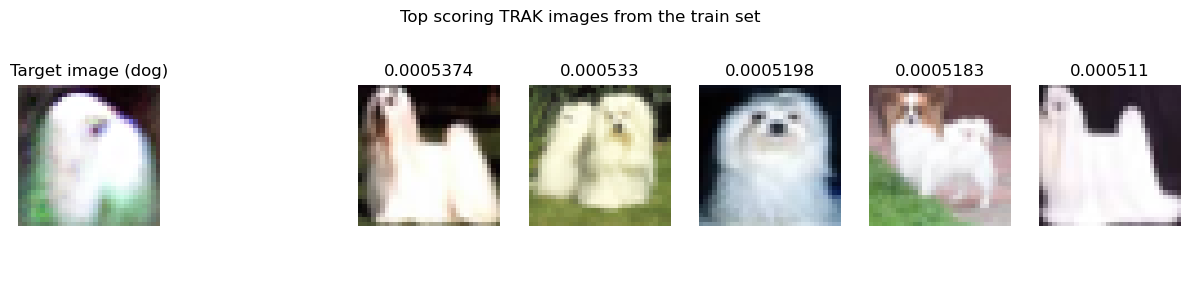

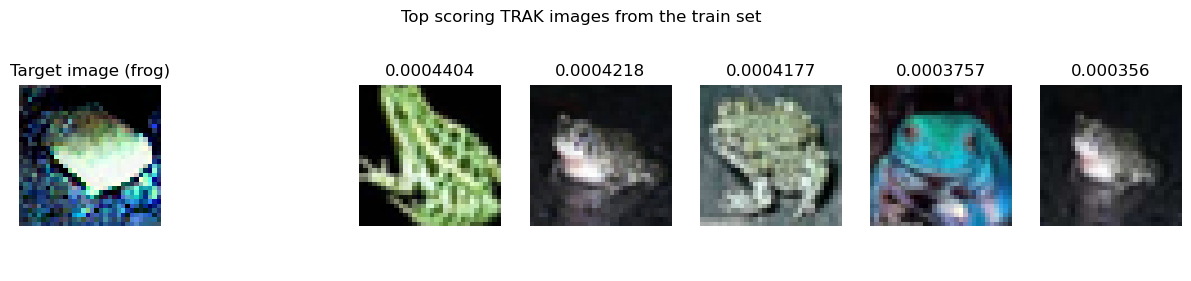

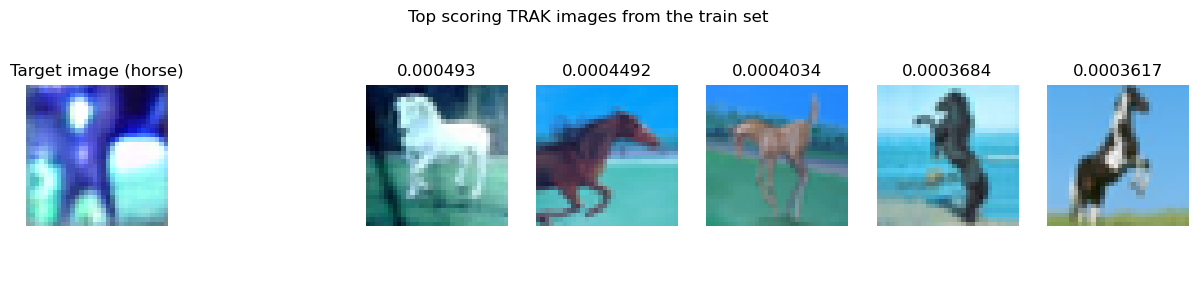

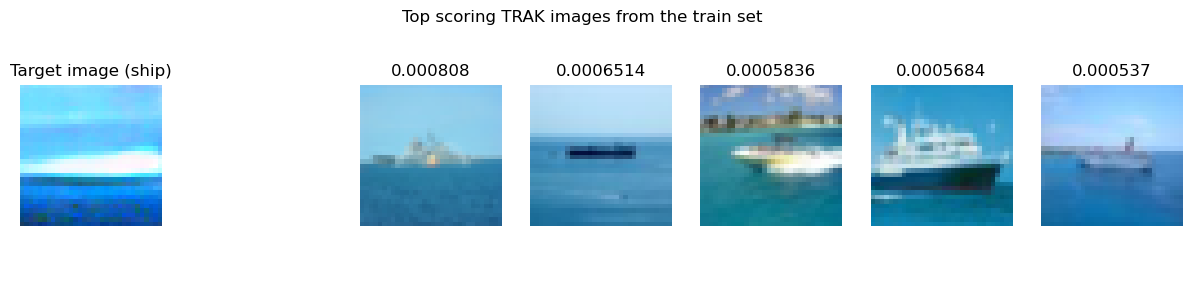

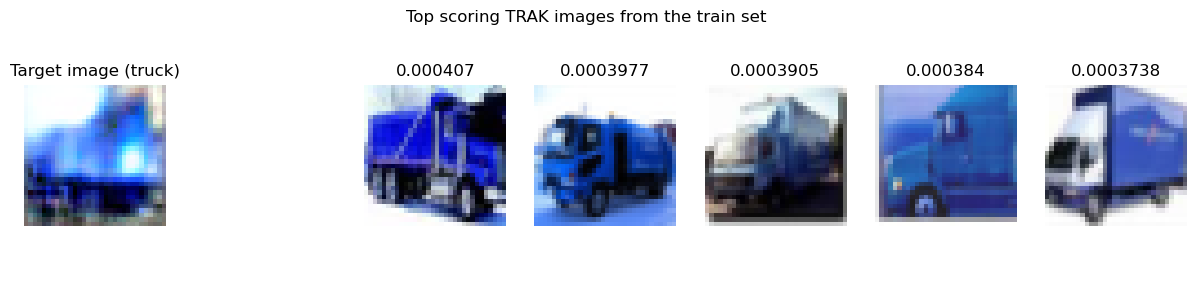

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#Adapted from https://github.com/MadryLab/trak/blob/main/examples/cifar_quickstart.ipynb

scores = trak_config.load_scores()

if CALCULATE_LDS:
    lds_score = LDS(project_config=project_config,
        training_dataset_config=train_dataset_config,
        generated_dataset_dataloader=generated_dataloader,
        training_dataset_type=dataset_type,
        generated_dataset_size=len(generated_dataset_config.dataset),
        attribution_scores_tau=scores,
        seed=42
    )
    print(f"LDS: {lds_score*100}%")

NUM_SEEDS = 20
SEED_TO_PREVIEW = 1
NUM_CLASSES = len(generated_dataset_config.class_captions)
for i in range(SEED_TO_PREVIEW,NUM_CLASSES*NUM_SEEDS,NUM_SEEDS):

    fig, axs = plt.subplots(ncols=7, figsize=(15, 3))
    fig.suptitle('Top scoring TRAK images from the train set')
    
    axs[0].imshow(generated_dataset[i][generated_dataset_config.image_column])
    
    axs[0].axis('off'); axs[0].set_title('Target image' + " (" + generated_dataset[i][generated_dataset_config.caption_column] + ")")
    axs[1].axis('off')
    
    top_trak_scorers = scores[:, i].argsort()[-5:][::-1]
    for ii, train_im_ind in enumerate(top_trak_scorers):
        axs[ii + 2].imshow(train_dataset[int(train_im_ind)][generated_dataset_config.image_column])
        axs[ii + 2].axis('off')
        axs[ii + 2].set_title(str(scores[int(train_im_ind),i]))

    fig.show()

## Counter Factuals

Next we use the attribution scores generated above to produce "counter factuals".
This works as follows:
- Pick a target test image
- Create a subset of the dataset where the top scoring images for this test image have been removed
- Generate a new "counter factual model" by training on this subset
- Use the "counter factual model" to generate a new image (the "counter factual image") using the same seed and prompt as the original target image


Ideally, the counter factual image will be very different from the original target image, since this means that the data that contributed the most to its creation has been removed.

In [9]:
from utils.dataset_utils import Dataset_Generator
dataset_config = CIFAR_10_Local_Config(
        project_config=project_config,
        dataset_type=dataset_type,)

cfds = Dataset_Generator(
    project_config=project_config,
    dataset_type=dataset_type,
    dataset_config=dataset_config,
)

In [10]:
prompts = train_dataset_config.class_captions

In [11]:
#I'm having exactly none of numpy's memmap BS today
scores_c = np.copy(scores)

The target image will be printed after this code block.

TARGET_CLASS: frog
TARGET_SEED: 1
TARGET_IMAGE: 6


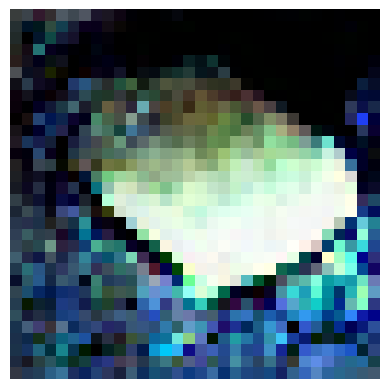

In [12]:
if dataset_type == Dataset_Type_Enum.CIFAR10:
    TARGET_CLASS = "frog"
if dataset_type == Dataset_Type_Enum.CIFAR2:
    TARGET_CLASS = "horse"
    
assert(TARGET_CLASS in prompts)
print(f"TARGET_CLASS: {TARGET_CLASS}")
print(f"TARGET_SEED: {SEED_TO_PREVIEW}")

TARGET_IMAGE = prompts.index(TARGET_CLASS) #Seed 1, frog
print(f"TARGET_IMAGE: {TARGET_IMAGE}")
plt.axis('off')
i = SEED_TO_PREVIEW+(TARGET_IMAGE*NUM_SEEDS)
plt.imshow(generated_dataset[i][generated_dataset_config.image_column])

top_trak_scorers = scores_c[:, i].argsort()[-1000:][::-1]

In [13]:
top_n_i_list = top_trak_scorers.tolist()

Next we generate the "Class Conformity" statistics. This looks at the number of images in the top 1,10,100 and 1000 that match the class of the target image.

Class conformity % (1): 100.0
Class conformity % (10): 100.0
Class conformity % (100): 97.0
Class conformity % (1000): 61.0


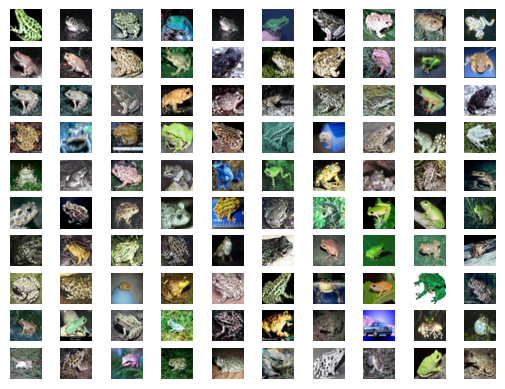

In [14]:
one_class_conformity = 0
ten_class_conformity = 0
hundred_class_conformity = 0
thousand_class_conformity = 0
num_images_per_axis = 10

for i in range(len(top_n_i_list)):
    if train_dataset_config.dataset[top_n_i_list[i]][train_dataset_config.caption_column] == TARGET_CLASS:
        if i<1:
            one_class_conformity += 1
        if i<10:
            ten_class_conformity += 1
        if i<100:
            hundred_class_conformity += 1
        if i<1000:
            thousand_class_conformity += 1
    
one_class_conformity_percentage = (one_class_conformity/1)*100
print(f"Class conformity % (1): {one_class_conformity_percentage}")
ten_class_conformity_percentage = (ten_class_conformity/10)*100
print(f"Class conformity % (10): {ten_class_conformity_percentage}")
hundred_class_conformity_percentage = (hundred_class_conformity/100)*100
print(f"Class conformity % (100): {hundred_class_conformity_percentage}")
thousand_class_conformity_percentage = (thousand_class_conformity/1000)*100
print(f"Class conformity % (1000): {thousand_class_conformity_percentage}")

for i in range(num_images_per_axis**2):
    plt.subplot(num_images_per_axis, num_images_per_axis, i+1)
    plt.axis('off')
    plt.imshow(train_dataset_config.dataset[top_n_i_list[i]][train_dataset_config.image_column])

num_images_per_axis = 10
for i in range(num_images_per_axis**2):
    plt.subplot(num_images_per_axis, num_images_per_axis, i+1)
    plt.axis('off')
    plt.imshow(train_dataset_config.dataset[top_n_i_list[i]][train_dataset_config.image_column])

Next we create the subset of the dataset with these top 1000 removed. This creates a config for the local CIFAR10 dataset.


In [15]:
MODEL_NAME_CLEAN = trak_config.MODEL_NAME_CLEAN

counter_factual_model_name = f"{TRAK_type}_{MODEL_NAME_CLEAN}_timestep_{TRAK_num_timesteps}_{TARGET_CLASS}_seed_{SEED_TO_PREVIEW}"

cfds.create_counterfactual_config(counter_factual_model_name,top_n_i_list)

Config DTRAK_sd1-lora_timestep_10_frog_seed_1 already exists!


False

This next block prints out the config name.

Copy this into ```training_scripts/\<dataset_name\>/train_sd1_(model_type)_counterfactuals.sh``` under the ```config_name``` line and run the script (details in the main project readme). We don't do this in this directly in this notebook since it will take 8-10 hours to train. Then come back and rerun this notebook from scratch.

In [16]:
print(counter_factual_model_name)

DTRAK_sd1-lora_timestep_10_frog_seed_1


In [17]:
from counter_factuals.counter_factuals_utils import Counter_Factual_Image_Generator

Make sure you have follows the instructions above! 

This block will error out the first time you run this because the counter factual model does not exist yet.

Loading pipeline components...:  86%|████████▌ | 6/7 [00:01<00:00,  4.35it/s]/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]


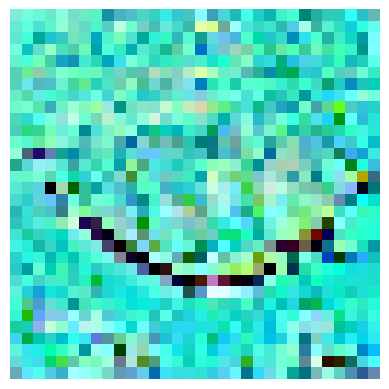

In [18]:
cfig = Counter_Factual_Image_Generator(
    project_config=project_config,
    counter_factual_model_name=counter_factual_model_name,
    model_type=model_type,
    dataset_type=dataset_type,
)

image = cfig.generate_counter_factual_image(
    seed=SEED_TO_PREVIEW,
    image_class=TARGET_CLASS,
    save_image=True,
    prompts=prompts,
)

plt.axis('off')
plt.imshow(image)